In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from typing import Callable
import SimpleITK as sitk
from torch.utils.data import DataLoader, Dataset
from os.path import abspath
from pathlib import Path
from monai import transforms as mt
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt
from monai.data import CacheDataset
from sklearn.model_selection import train_test_split
import numpy as np

d:\AI_2\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed42 = 42

## Data Loading

In [3]:
def collect_samples(root: Path, is_test: bool = False) -> list[dict[str, Path]]:
    """
    Collects the samples from the WMH dataset.

    Parameters
    ----------
    root : Path
        The root directory of the dataset.
    is_test : bool
        Whether to collect the test set or the training set.

    Returns
    -------
    list[dict[str, Path]]
        A list of dictionaries containing the image and label paths.
    """
  
    samples = []
    # Iterate through each subject directory
    for subject_dir in root.iterdir():
        if subject_dir.is_dir():  # Check if it's a directory
            flair_path = subject_dir / "FLAIR.nii.gz"
            t1_path = subject_dir / "T1.nii.gz"
            WMH_path = subject_dir / "wmh.nii.gz"
            
            # Check if all required files exist
            if flair_path.exists() and t1_path.exists() and WMH_path.exists():
                sample = {
                    "flair": flair_path,
                    "t1": t1_path,
                    "WMH": WMH_path
                }
                samples.append(sample)
            else:
                print(f"Missing files in {subject_dir}: "
                      f"{'FLAIR' if not flair_path.exists() else ''} "
                      f"{'T1' if not t1_path.exists() else ''} "
                      f"{'wmh' if not WMH_path.exists() else ''}")

    return samples

In [5]:
# Note from lars: I've changed the keys from [image, label] to the keynames our dataset uses
# Source: https://docs.monai.io/en/stable/transforms.html#maptransform
# However for the rest i'm unfamilier with what this code does exactly
# For instance does it make sence to apply some transforms to to our input but not our labels?
# TODO - *Eva* can you see if you can understand this? since it's data augmentation i think.


# Note from lars: What compose does: 
# provides the ability to chain a series of callables together in a sequential manner. 
# Each transform in the sequence must take a single argument and return a single value.
train_transforms = mt.Compose([
    mt.LoadImaged(keys=["flair", "t1", "WMH"]),
    mt.EnsureChannelFirstd(keys=["flair", "t1", "WMH"]),
    mt.RandSpatialCropd(keys=["flair", "t1", "WMH"], roi_size=(32, 32, 32)),  # Crop all to the same shape
    #mt.ResizeD(keys=["flair", "t1", "WMH"], spatial_size=(128, 128, 128)),  # Resize all to the same shape #TODO - remove?
    mt.NormalizeIntensityd(keys=["flair", "t1"])
])

val_transforms = mt.Compose([
    mt.LoadImaged(keys=["flair", "t1", "WMH"]),
    mt.EnsureChannelFirstd(keys=["flair", "t1", "WMH"]),
    #mt.ResizeD(keys=["flair", "t1", "WMH"], spatial_size=(128, 128, 128)),  # Resize validation too #TODO - remove?
    mt.NormalizeIntensityd(keys=["flair", "t1"])
])
    # You can add more transforms here! See
    # https://docs.monai.io/en/stable/transforms.html#dictionary-transforms


# Actually running loading 
# TODO - *Bas, Eva, Ishar* Create a data folder and put the wmh data there in accordance with this path
root = Path(abspath(""))
wmh_path = root.joinpath("D:\WMH\WMH")
sample_paths = [item for item in wmh_path.iterdir() if item.is_dir()]
samples = []

for sample_path in sample_paths:
    samples.extend(collect_samples(sample_path))

# You might get an error here, make sure you install the required extra dependencies
# https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

# Randomly shuffeling the dataset
# samples = samples[0::5] #TODO - *Samar* REMOVE!!!! This is only used for faster debugging
train_samples, temp_samples = train_test_split(samples, train_size=0.8, random_state=seed42, shuffle=True)
val_samples, test_samples = train_test_split(temp_samples, test_size=0.5, random_state=seed42, shuffle=True)

## Data exploration

In [6]:
def load_nifti_image(image_path: Path):
    """Load a NIfTI image using SimpleITK."""
    image = sitk.ReadImage(str(image_path))
    return sitk.GetArrayFromImage(image)  # Convert to NumPy array

In [7]:
# Print the shapes of each example in the WMH dataset before data augmentation and shuffeling:
# This is data from Utrecht (index: [0:19]), Singapor (index: [20:39]), Amsterdam (index: [40:59])
# The shapes are: (48, 240, 240), (48, 256, 232), (83, 256, 132)
for index, sample in enumerate(samples):
    print(f"{index} FLAIR: {load_nifti_image(sample['flair']).shape}, FLAIR: {load_nifti_image(sample['t1']).shape}, FLAIR: {load_nifti_image(sample['WMH']).shape}")

0 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
1 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
2 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
3 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
4 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
5 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
6 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
7 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
8 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
9 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
10 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
11 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
12 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
13 FLAIR: (83, 256, 132), FLAIR: (83, 256, 132), FLAIR: (83, 256, 132)
14 FLAIR: (83, 2

In [8]:
# Print the shapes of each example in the WMH dataset after augmentation:
# for i in train_samples:
#     print(f"FLAIR: {i['flair'].shape}, FLAIR: {i['t1'].shape}, FLAIR: {i['WMH'].shape}")

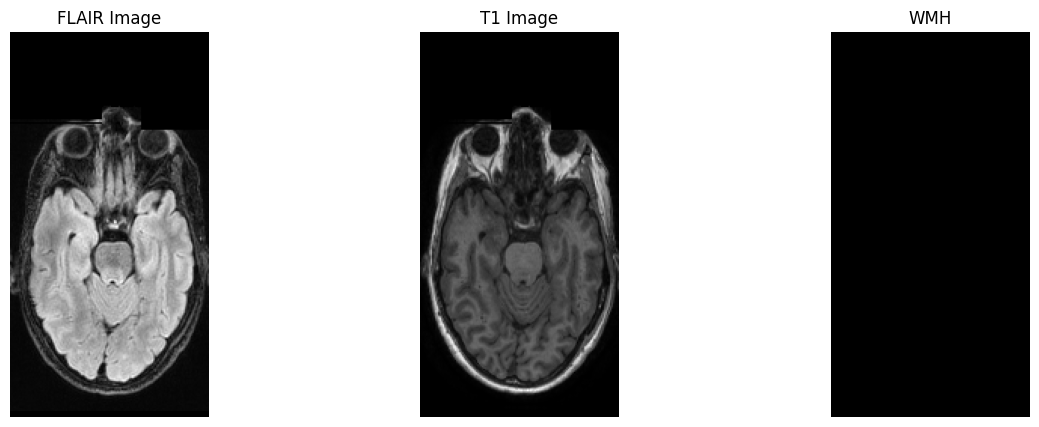

60

In [9]:
def visualize_sample(sample):
    """Visualize FLAIR, T1, and WMH images from a sample."""
    flair_image = load_nifti_image(sample['flair'])
    t1_image = load_nifti_image(sample['t1'])
    label_image = load_nifti_image(sample['WMH'])

    # Select a slice to visualize (e.g., the middle slice)
    slice_index = flair_image.shape[0] // 2

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # FLAIR Image
    axes[0].imshow(flair_image[slice_index, :, :], cmap='gray')
    axes[0].set_title('FLAIR Image')
    axes[0].axis('off')

    # T1 Image
    axes[1].imshow(t1_image[slice_index, :, :], cmap='gray')
    axes[1].set_title('T1 Image')
    axes[1].axis('off')

    # WMH Label
    axes[2].imshow(label_image[slice_index, :, :], cmap='gray')
    axes[2].set_title('WMH')
    axes[2].axis('off')

    plt.show()

# Visualize the first sample if available
if samples:
    visualize_sample(samples[0])  # Visualize the first sample
else:
    print("No samples found to visualize.")
len(samples)

## Model setup

In [10]:
torch.manual_seed(seed=seed42)

In [11]:
class DoubleConv(nn.Module):
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int,
        use_normalization: bool = True,
    ) -> None:
        super().__init__()

        # For now we are just considering 2d input
        # Thus expected input dimensions is [batch_size, channels, height, width] 
        # Or when not using batches [channels, height, width]
        # Or in the convention of pytorch: (N, C, H, W) or (C, H, W)

        # nn.Identity just return it's input so it's used as a replacement for normalization if normalization is not used
        # TO DO: find out what batchnorm does exactly
        # TO DO: Find out how exactly relu works
        
        conv = None
        norm = None

        if n_dims == 2:
            conv = nn.Conv2d
            norm = nn.BatchNorm2d if use_normalization else nn.Identity
        elif n_dims == 3:
            conv = nn.Conv3d
            norm = nn.BatchNorm3d if use_normalization else nn.Identity
        else:
            raise ValueError("Invalid number of dimensions, Either choose 2 for 2 dimensional input or 3 for 3 dimensional input.")
        
        layers = [
            conv(in_channels , out_channels , kernel_size=3, padding=1),   
            norm(out_channels),                               
            nn.ReLU(inplace=True),                        
            conv(out_channels , out_channels , kernel_size=3, padding=1),         
            norm(out_channels),                                      
            nn.ReLU(inplace=True),                          
        ]

        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)
    
class EncoderBlock(nn.Module):
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int,
        use_normalization: bool = True,
    ) -> None:
        super().__init__()

        pool = None
        if n_dims == 2:
            pool = nn.MaxPool2d
        elif n_dims == 3:
            pool = nn.MaxPool3d
        else:
            raise ValueError("Invalid number of dimensions, Either choose 2 for 2 dimensional input or 3 for 3 dimensional input.")
        
        self.encode = nn.Sequential(
            pool(kernel_size=2, stride=2),
            DoubleConv(n_dims, in_channels, out_channels, use_normalization),
        )

    def forward(self, x):
        return self.encode(x)

class DecoderBlock(nn.Module):
    '''
    Creates an instance of the decoder block in a UNet. The decoder block consist of the following:
    Upsample ->(+Skip connection) Convolutional layer -> Convolutional layer
    '''
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int,
        use_transpose: bool = False,
        use_normalization: bool = True,
    ) -> None:
        super().__init__()

        ### Pick upsample method
        conv = None

        ## 2 Dimensions
        if n_dims == 2:
            conv = nn.Conv2d

            # Two methods to upsample: transpose or with interpolation
            # Upsample the spatial dimensions (height, width) and reduce the number of channels by half.
            # Kernel size 2 and stride 2 for conv transpose is essential here to double the spatial dimensions
            if use_transpose:
                self.upsample = nn.ConvTranspose2d(in_channels , out_channels , kernel_size=2, stride=2)  # We cut the number of in-channels in half.
            else:
                # This upsample method uses a algorithm instead learned weights and can have artifects
                # The convolutional layer right after it is meant to deal with those artifacts
                self.upsample = nn.Sequential(  
                    nn.Upsample(scale_factor= 2, mode="bilinear", align_corners=True),
                    conv(in_channels , out_channels , kernel_size=1, padding=0),  
                )

        ## 3 Dimensions
        elif n_dims == 3:
            conv = nn.Conv3d

            # Same as with the 2D case. 
            if use_transpose:
                self.upsample = nn.ConvTranspose3d(in_channels, out_channels , kernel_size=2, stride=2)
            else:
                self.upsample = nn.Sequential(
                    nn.Upsample(scale_factor= 2, mode="trilinear", align_corners=True),
                    conv(in_channels, out_channels, kernel_size=1, padding=0),
                )

        ## Just
        self.decode = DoubleConv(n_dims, in_channels, out_channels, use_normalization)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = self.upsample(x)
        
        # This is the skip connection
        x = torch.cat((x, skip), dim=1)
        x = self.decode(x)
        return x

class UNet(nn.Module):
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int,
        base_channels: int = 8,
        depth: int = 4,
        use_transpose: bool = False,
        use_normalization: bool = True,
        final_activation: nn.Module | None = None,
    ) -> None:
        super().__init__()

        self.n_dims = n_dims
        self.depth = depth

        if depth < 2:
            raise ValueError("Model depth must be 2 or greater")
        
        # Define the input layer
        layers = [DoubleConv(n_dims, in_channels , base_channels, use_normalization)]
        
        
        # Define the encoder path: it progressively doubles the number of channels
        current_features = base_channels
        for _ in range(depth - 1):
            layers.append(EncoderBlock(n_dims, current_features, current_features*2, use_normalization))
            current_features *= 2

        # Define the decoder path: progressively halves the number of channels
        for _ in range(depth - 1):
            layers.append(DecoderBlock(n_dims, current_features, current_features//2, use_transpose, use_normalization))
            current_features //= 2
        
        # Define the output layer
        if n_dims == 2:
            layers.append(nn.Conv2d(current_features, out_channels, kernel_size=1))
        elif n_dims == 3:
            layers.append(nn.Conv3d(current_features, out_channels, kernel_size=1))
        else:
            raise ValueError("Invalid number of dimensions")
        
        self.layers = nn.ModuleList(layers)
        if final_activation is not None:
            self.final_activation = final_activation
        else:
            self.final_activation = nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        xi = [self.layers[0](x)]

        # Encoder path
        # Pretty simple, just loop over the encoder blocks
        for layer in self.layers[1:self.depth]:
            xi.append(layer(xi[-1]))

        
        # Decoder path
        # We need to loop over the decoder blocks, but also need to
        # keep track of the skip connections
        for i, layer in enumerate(self.layers[self.depth:-1]):
            xi[-1] = layer(xi[-1], xi[-2 - i])
        
        return self.final_activation(self.layers[-1](xi[-1]))

In [12]:
# Testing model creation:
model = UNet(n_dims= 2, in_channels=1, out_channels=2, depth=3)

model.layers


ModuleList(
  (0): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (1): EncoderBlock(
    (encode): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, a

## Model training

In [117]:
class ModelTraining():
    def __init__(
        self,
        n_dims: int,
        n_epochs: int,
        batch_size: int,
        learning_rate: float,
        loss_fn: list, # changed to accept lists 
        checkpoint_path: str,
        train_samples: list,
        val_samples: list,
        train_transforms: mt.compose.Compose = None,
        val_transforms: mt.compose.Compose = None,
        use_sliding_window: bool = False
    ) -> None:
        self.use_sliding_window = use_sliding_window
        self.batch_size = batch_size
        self.checkpoint_path = Path(checkpoint_path)
        
        self.train_transforms, self.val_transforms = train_transforms, val_transforms
        self.train_dl, self.val_dl = self._load_samples(train_samples, val_samples)
        self.n_epochs = n_epochs
        self.starting_epoch = 0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = loss_fn

        self.epoch_train_losses = []
        self.epoch_val_losses = []

        if n_dims == 3:
            self.model = UNet(n_dims=n_dims, in_channels=1, out_channels=1, depth=3).to(self.device)
        elif n_dims == 2:
            # take only middle slices
            self.train_dl, self.val_dl = self._take_middle_slices()
            self.model = UNet(n_dims=n_dims, in_channels=1, out_channels=1, depth=3).to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    
    def run_training_loop(self):
        for epoch in (prog_bar := tqdm(range(self.starting_epoch, self.n_epochs), desc="Training", unit="epoch", total=self.n_epochs, position=0)):
            print(f"Starting epoch number: #{epoch}")
            prog_bar.set_description(f"Training Loop")
            train_losses = self._loop_train()

            # Calculate average losses for each loss function during training
            avg_train_losses = [sum(losses) / len(losses) for losses in zip(*train_losses)]
            prog_bar.set_postfix({
            f"Training Loss {i+1}": avg_loss for i, avg_loss in enumerate(avg_train_losses)
            })

            prog_bar.set_description(f"Validation Loop")
            val_losses = self._loop_validate()
            
            # Calculate average losses for each loss function during validation
            avg_val_losses = [sum(losses) / len(losses) for losses in zip(*val_losses)]

            # Log the losses
            print(f"#{epoch}# Training Losses: {avg_train_losses}, Validation Losses: {avg_val_losses}")
            
            # Append individual loss averages for each loss function
            self.epoch_train_losses.append(avg_train_losses)
            self.epoch_val_losses.append(avg_val_losses)

            # Create checkpoint (no change needed here)
            self._create_checkpoint(epoch)
    
    def _loop_train(self):
        self.model.train()
        train_losses = []

        # for i, batch in tqdm(enumerate(self.train_dl), total=len(self.train_dl), desc="Training", unit="batch", position=1, leave=False):
        for i, batch in enumerate(self.train_dl):
            
            image, label = batch["flair"].to(self.device), batch["WMH"].to(self.device)

            self.optimizer.zero_grad() # Clear gradients
            output = self.model(image) # Model forward pass

            # NOTE if we want to use this we need to adjust self._load_samples
            # if self.use_sliding_window: #TODO - remove this block 
            #     output = sliding_window_inference(
            #         image,
            #         (32, 32, 32),
            #         self.sw_batch_size,
            #         self.model,
            #         overlap=0.25,
            #         mode="gaussian",
            #         progress=True,
            #     )
            # else:
            #     output = self.model(image)
            
            # Using multiple loss functions at a time
            individual_losses = [fn(output, label) for fn in self.loss_fn]
            # If the loss is a tensor, use .item() to get the scalar
            individual_losses = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in individual_losses]

            # Backpropagate using the sum of losses
            total_loss = sum(fn(output, label) for fn in self.loss_fn)
            total_loss.backward()  # Backpropagation
            self.optimizer.step()  # Update model weights

            # Append individual losses for this batch
            train_losses.append(individual_losses)

        return train_losses

    def _loop_validate(self):
        self.model.eval() # We set the model in evaluation mode
        val_losses = []
        # for i, batch in tqdm(enumerate(self.val_dl), total=len(self.val_dl), desc="Validation", unit="batch", position=1, leave=False):
        for i, batch in enumerate(self.val_dl):
            # TODO - *Samar* implement also for T1
            image, label = batch["flair"].to(self.device), batch["WMH"].to(self.device)

            with torch.no_grad():
                if self.use_sliding_window:
                    output = sliding_window_inference(
                        image,
                        (32, 32, 32),
                        self.batch_size * 4,
                        self.model,
                        overlap=0.25,
                        mode="gaussian",
                        progress=True,
                    )
                else:
                    output = self.model(image)


                # Calculate and store individual losses
            individual_losses = [fn(output, label) for fn in self.loss_fn]
            # If the loss is a tensor, use .item() to get the scalar
            individual_losses = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in individual_losses]
            val_losses.append(individual_losses)

        return val_losses

    def _load_samples(self, train_samples, val_samples):
        train_samples = CacheDataset(data=train_samples, transform=self.train_transforms)
        train_dl = DataLoader(train_samples, batch_size=self.batch_size, shuffle=True)
        
        val_samples = CacheDataset(data=val_samples, transform=self.val_transforms)
        if self. use_sliding_window:
            val_dl = DataLoader(val_samples, batch_size=1, shuffle=False)
        else:
            val_dl = DataLoader(val_samples, batch_size=self.batch_size, shuffle=False)

        return train_dl, val_dl
    
    def _create_checkpoint(self, epoch):
        self.checkpoint_path.parent.mkdir(parents=True, exist_ok=True)
        
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "train_losses": self.epoch_train_losses,
                "val_losses": self.epoch_val_losses,
            },
            self.checkpoint_path
        )

    def load_checkpoint(self):
        checkpoint = torch.load(self.checkpoint_path, weights_only=True)
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

        self.starting_epoch = checkpoint["epoch"] + 1
        self.epoch_train_losses = checkpoint["train_losses"]
        self.epoch_val_losses = checkpoint["val_losses"]

    def _separate_slices(self):
        pass #TODO - maybe implement, depending on data augmentation, each slice will run differently


In [110]:

from model_evaluation import DiceLoss, F1Score,LesionSensitivity


In [118]:
loss_functions = [nn.BCEWithLogitsLoss(),F1Score(),LesionSensitivity(),DiceLoss()] #TODO - add different loss functions to evaluate

Model_training_sw = ModelTraining(
    n_dims = 3,
    n_epochs = 2,
    batch_size = 4,
    learning_rate = 1e-3,
    loss_fn = loss_functions,  ## experimenting with different losses by providing a list 
    checkpoint_path = "./data/checkpoints/model_checkpoint.ckpt",
    train_samples = train_samples,
    val_samples = val_samples,
    train_transforms = train_transforms,
    val_transforms = val_transforms,
    use_sliding_window = True
    )

Loading dataset: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


In [119]:
Model_training_sw.run_training_loop()

Training Loop:   0%|          | 0/2 [00:00<?, ?epoch/s]

Starting epoch number: #0


Training Loop:  50%|█████     | 1/2 [00:17<00:17, 17.41s/epoch, Training Loss 1=0.516, Training Loss 2=0.0113, Training Loss 3=0.19, Training Loss 4=0.989]  

#0# Training Losses: [0.5155816674232483, 0.011336934634061447, 0.19027787267385365, 0.9886630972226461], Validation Losses: [0.4933455189069112, 0.00581270950109077, 1.75563850629757e-08, 0.9941873053709666]
Starting epoch number: #1


Validation Loop: 100%|██████████| 2/2 [00:34<00:00, 17.44s/epoch, Training Loss 1=0.465, Training Loss 2=0.0058, Training Loss 3=2.23e-7, Training Loss 4=0.994]

#1# Training Losses: [0.46509267886479694, 0.005796808974385688, 2.2299922363290449e-07, 0.9942032098770142], Validation Losses: [0.445506493250529, 0.004730553048527024, 0.005650125880933935, 0.9952694773674011]


In [120]:
Model_training_sw.load_checkpoint()
Model_training_sw.run_training_loop()

Training:   0%|          | 0/2 [00:00<?, ?epoch/s]


## BraTS dataset

In [57]:
import os
import nibabel as nib
from pathlib import Path
import cv2
import numpy as np
from scipy.ndimage import zoom
# Specify the directory containing the .nii.gz files
dataset_path = Path(r"C:/Users/20213084/OneDrive - TU Eindhoven/Desktop/8UU22/Group project/BraTS/BraTS/Data/BraTS2021_00002")
resized_data_dict = {}
# List all .nii.gz files in the directory
nii_files = list(dataset_path.glob("*.nii.gz"))
new_shape = (132, 256, 83)  # Change this to your desired shape
# Load each .nii.gz file and print its shape
for nii_file in nii_files:
    img = nib.load(nii_file)
    data = img.get_fdata()  # Get the image data as a NumPy array
    print(f"Loaded {nii_file.name} with original shape: {data.shape}")  # Height, Width, Depth

    # Calculate the zoom factors for each dimension
    zoom_factors = [new_dim / old_dim for new_dim, old_dim in zip(new_shape, data.shape)]
    
    # Resize the data using zoom
    resized_data = zoom(data, zoom_factors, order=1)  # Use order=1 for linear interpolation
    resized_data_dict[nii_file.name] = resized_data
    print(f"Resized {nii_file.name} to shape: {resized_data.shape}")  # New shape

Loaded BraTS2021_00002_flair.nii.gz with original shape: (240, 240, 155)
Resized BraTS2021_00002_flair.nii.gz to shape: (132, 256, 83)
Loaded BraTS2021_00002_seg.nii.gz with original shape: (240, 240, 155)
Resized BraTS2021_00002_seg.nii.gz to shape: (132, 256, 83)
Loaded BraTS2021_00002_t1.nii.gz with original shape: (240, 240, 155)
Resized BraTS2021_00002_t1.nii.gz to shape: (132, 256, 83)
Loaded BraTS2021_00002_t1ce.nii.gz with original shape: (240, 240, 155)
Resized BraTS2021_00002_t1ce.nii.gz to shape: (132, 256, 83)
Loaded BraTS2021_00002_t2.nii.gz with original shape: (240, 240, 155)
Resized BraTS2021_00002_t2.nii.gz to shape: (132, 256, 83)


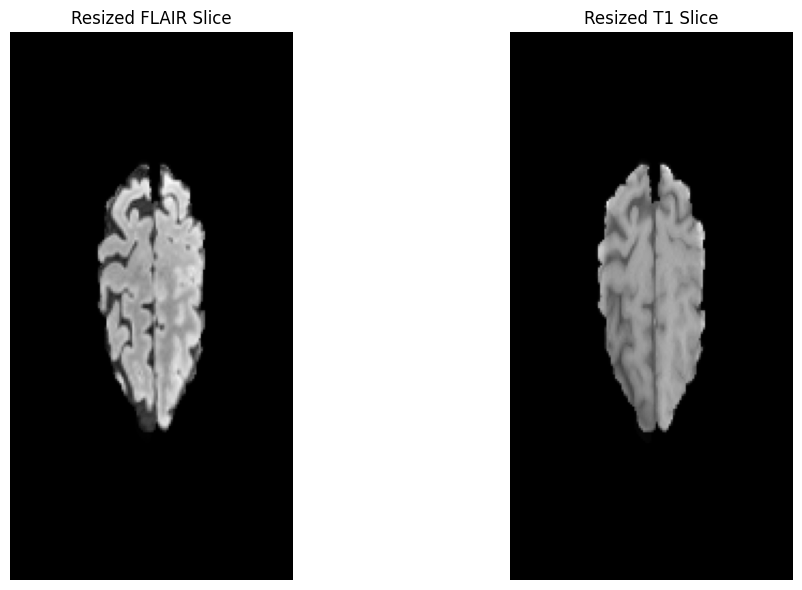

In [58]:
# Visualize the resized FLAIR and T1 images
for key in resized_data_dict.keys():
    if key.endswith('flair.nii.gz'):
        flair_data = resized_data_dict[key]
    elif key.endswith('t1.nii.gz'):
        t1_data = resized_data_dict[key]

# Check if both images are loaded
if flair_data is not None and t1_data is not None:
    # Get the middle slice index
    slice_index = flair_data.shape[0] // 2  # Assuming both have the same depth

    # Extract slices
    flair_slice = flair_data[:, :, slice_index]
    t1_slice = t1_data[:, :, slice_index]

    # Plot the slices side by side
    plt.figure(figsize=(12, 6))  # Set the figure size
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(flair_slice.T, cmap='gray', origin='lower')  # Transpose for correct orientation
    plt.title('Resized FLAIR Slice')
    plt.axis('off')  # Turn off axis

    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(t1_slice.T, cmap='gray', origin='lower')  # Transpose for correct orientation
    plt.title('Resized T1 Slice')
    plt.axis('off')  # Turn off axis

    plt.tight_layout()  # Adjust layout
    plt.show()
else:
    print("FLAIR or T1 data not found.")

In [59]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import SimpleITK as sitk
import torch
#class_1_images = []
# Define the path to the dataset directory
#dataset_dir = Path(r"C:/Users/20213084/OneDrive - TU Eindhoven/Desktop/8UU22/Group project/BraTS/BraTS/Data/BraTS2021_00002")
# Iterate through all .nii.gz files in the dataset directory
for segmentation_file in dataset_path.glob("**/*seg.nii.gz"):
    # Read the segmentation mask
    segmentation_image = sitk.ReadImage(str(segmentation_file))
    
    # Convert the SimpleITK image to a NumPy array
    segmentation_array = sitk.GetArrayFromImage(segmentation_image)
    class_1_array = np.where(segmentation_array == 1, 1, 0)  # Retain class 1, set others to 0
    #class_1_images.append(class_1_array)
    # Print the shape of the segmentation array
    #print(f"Processing file: {segmentation_file.name}")
    #print(f"Shape: {segmentation_array.shape}")
    
    # Print the unique classes in the segmentation mask
    unique_classes = np.unique(segmentation_array)
    print(f"Unique classes: {unique_classes}")  # 0= Background, 1=Necrotic and non-enhancing tumour core, 2=Peritumoral edema, 4=Enhancing tumour

Unique classes: [0 1 2 4]


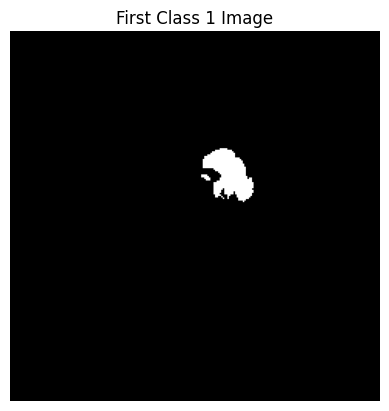

In [60]:
import matplotlib.pyplot as plt

# Assuming class_1_images is already populated with the extracted class 1 images

# Check if there are any class 1 images
    # Get the first class 1 image
first_class_1_image = class_1_array
middle_index = first_class_1_image.shape[0]//2
    # Display the first image
plt.imshow(first_class_1_image[middle_index], cmap='gray', vmin=0, vmax=1)  # Display the first slice of the 3D image
plt.title("First Class 1 Image")
plt.axis('off')  # Hide axis
plt.show()

In [18]:
Model_training.run_training_loop()

Training Loop:   0%|          | 0/2 [00:13<?, ?epoch/s]


KeyboardInterrupt: 